In [1]:
import os
import numpy as np

import tensorflow as tf
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, Input, Lambda
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
# Diretório com suas imagens
data_dir = 'C:/Users/estela.ribeiro/JupyterNotebooks/side_job_breat_cancer/dataset/images/'

# Lista para armazenar imagens e rótulos
images = []
labels = []

# Loop sobre os arquivos no diretório
for filename in os.listdir(data_dir):
    if filename.endswith('.png'):  # Supondo que suas imagens tenham extensão .jpg
        img = load_img(os.path.join(data_dir, filename), target_size=(300, 300))
        img_array = img_to_array(img)
        images.append(img_array)
        
        # Extrair rótulo do nome do arquivo
        label = filename.split(' ')[0]  # Pega o rótulo antes do espaço em branco
        labels.append(label)

In [4]:
# Codificar rótulos em números
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)

# Converter para array numpy
images = np.array(images)
labels = to_categorical(labels)

In [5]:
labels.shape, images.shape

((780, 3), (780, 300, 300, 3))

In [6]:
# Dividir os dados em conjuntos de treinamento e validação
X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.2, shuffle=True, random_state=42)

In [7]:
# Calcular pesos das classes baseados na distribuição dos dados
class_weights = {}
total_samples = len(y_train)
num_classes = len(np.unique(np.argmax(y_train, axis=1)))
for i in range(num_classes):
    class_count = np.sum(np.argmax(y_train, axis=1) == i)
    class_weights[i] = total_samples / (num_classes * class_count)

In [8]:
input_shape=(300,300,3)
num_class=3

# Carregar o modelo VGG-16 pré-treinado
base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

# Congelar as camadas do modelo base
for layer in base_model.layers:
    layer.trainable = False

inputs = Input(shape=input_shape)
x = Lambda(preprocess_input)(inputs)  # Aplicando a função preprocess_input como uma camada Lambda
x = base_model(x, training=False)  # Modo de inferência para base_model
# Adicionar camadas personalizadas
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(num_class, activation='softmax')(x)
model = Model(inputs, predictions)

# Compilar o modelo
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

In [9]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 300, 300, 3)]     0         
                                                                 
 lambda (Lambda)             (None, 300, 300, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 9, 9, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 41472)             0         
                                                                 
 dense (Dense)               (None, 256)               10617088  
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 3)                 771   

In [10]:
# Treinar o modelo
model.fit(X_train, y_train, epochs=5, validation_data=(X_val, y_val), class_weight=class_weights)

Epoch 1/5


20/20 [==============================] - 647s 33s/step - loss: 14.7729 - accuracy: 0.5417 - val_loss: 3.2281 - val_accuracy: 0.6026
Epoch 2/5
20/20 [==============================] - 616s 31s/step - loss: 1.0802 - accuracy: 0.7612 - val_loss: 0.6488 - val_accuracy: 0.7885
Epoch 3/5
20/20 [==============================] - 616s 31s/step - loss: 0.3733 - accuracy: 0.8429 - val_loss: 0.7684 - val_accuracy: 0.7628
Epoch 4/5
20/20 [==============================] - 652s 33s/step - loss: 0.2639 - accuracy: 0.8894 - val_loss: 0.6269 - val_accuracy: 0.8397
Epoch 5/5
20/20 [==============================] - 676s 34s/step - loss: 0.2420 - accuracy: 0.9103 - val_loss: 0.6491 - val_accuracy: 0.8333


In [11]:
# Avaliar o desempenho do modelo
loss, accuracy = model.evaluate(X_val, y_val)
print("Loss:", loss)
print("Accuracy:", accuracy)

5/5 [==============================] - 144s 29s/step - loss: 0.6491 - accuracy: 0.8333
Loss: 0.6490617990493774
Accuracy: 0.8333333134651184


In [12]:
# Fazer previsões no conjunto de validação
y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_val, axis=1)

5/5 [==============================] - 144s 28s/step


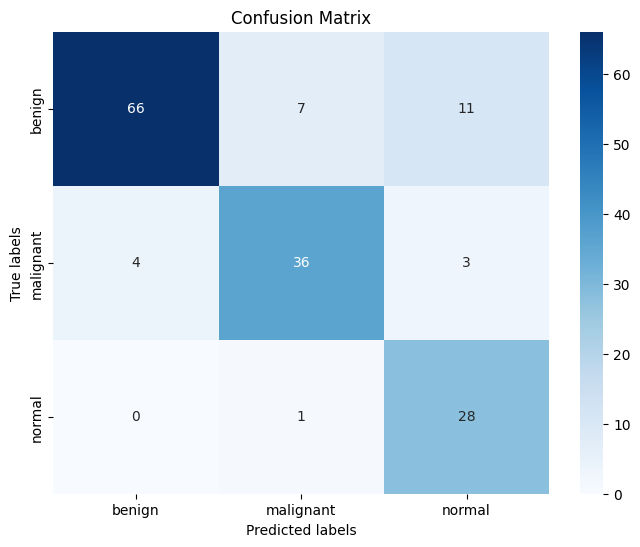

In [13]:
# Calcular a matriz de confusão
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Plotar a matriz de confusão
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=label_encoder.classes_, 
            yticklabels=label_encoder.classes_)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()